In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from statsmodels.graphics.tsaplots import plot_acf 

%matplotlib inline
rcParams['figure.figsize'] = 15,6

In [2]:
df_train = pd.read_csv(r'D:\ML\kaggle\Bike sharing demand\data\train.csv')
df_test = pd.read_csv(r'D:\ML\kaggle\Bike sharing demand\data\test.csv')

print('Dimensions of the original training dataset: ', df_train.shape)
print('Dimensions of the original test dataset: ', df_test.shape)

Dimensions of the original training dataset:  (10886, 12)
Dimensions of the original test dataset:  (6493, 9)


Functions to be used in this project

In [3]:
# Function for merging training and test dataset.
def df_concat(df1, df2):
    df = pd.concat([df1, df2], axis = 0, sort = False).reset_index(drop=True)
    return df

# Function for splitting dataset into training and test set.
def df_split(df, df1_num):
    df1 = df.loc[:df1_num-1, :].reset_index(drop = True)
    df2 = df.loc[df1_num:,:].reset_index(drop = True)
    return df1, df2

# Function for evaluating Root Mean Squared Logarithmic Error (RMSLE) considering log transformation. 
def rmsle_score(y, y_, convertExp = False):
    if convertExp:
        y = np.exp(y)
        y_ = np.exp(y_)
    score = np.sqrt(np.mean((np.log1p(y) - np.log1p(y_))**2))
    return score

In [4]:
print(df_train.head())
print(df_test.head())

         datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011/1/1 00:00       1        0           0        1  9.84  14.395   
1  2011/1/1 01:00       1        0           0        1  9.02  13.635   
2  2011/1/1 02:00       1        0           0        1  9.02  13.635   
3  2011/1/1 03:00       1        0           0        1  9.84  14.395   
4  2011/1/1 04:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-2

Features 'casual', 'registered' are in the training data 'count' stands for label.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


There are no missing values, so no need to handle this part.

In [7]:
print(df_train.shape)
print(df_test.shape)

(10886, 12)
(6493, 9)


'holiday' does not include weekend. TBD try to include Saturday and Sunday to 'holiday' 
i.e. change values on Saturday and Sunday to 1 on 'holiday' feature

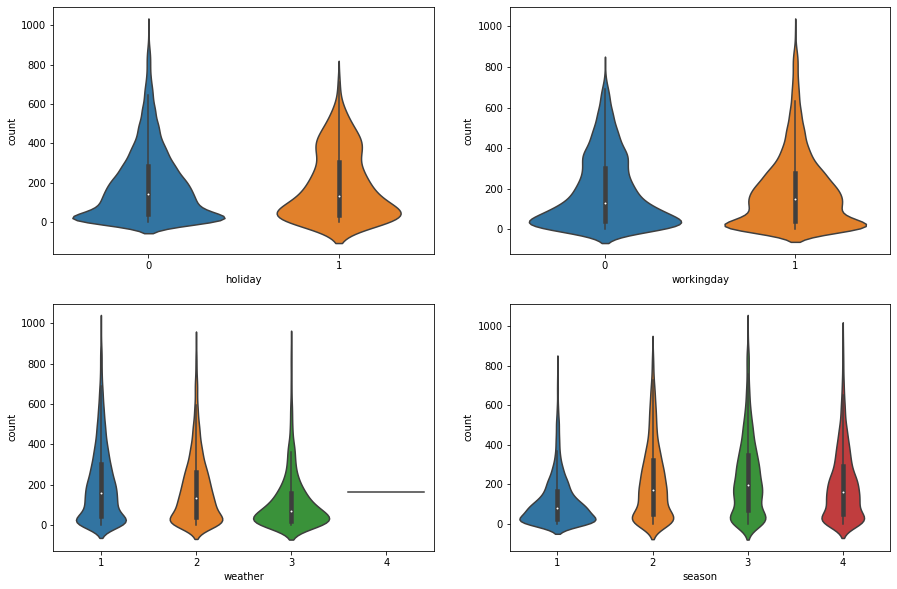

In [8]:
f, axes = plt.subplots(2,2, figsize = (15,10))
sns.violinplot(df_train['holiday'], df_train['count'], ax = axes[0,0])
sns.violinplot(df_train['workingday'], df_train['count'], ax = axes[0,1])
sns.violinplot(df_train['weather'], df_train['count'], ax = axes[1,0])
sns.violinplot(df_train['season'], df_train['count'], ax = axes[1,1])

Remove outliers according to 'count'

Outlier limit =  735.007493403403
Number of training data after removing outliers:  (10739, 12)


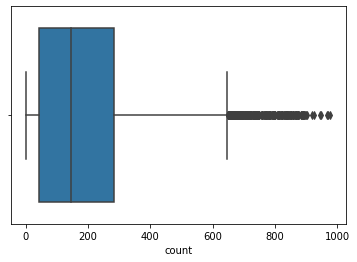

In [9]:
sns.boxplot(x = df_train['count'])
limit = df_train['count'].mean() + 3*df_train['count'].std()
print('Outlier limit = ', limit)
df_train = df_train.loc[df_train['count'] <= limit, :]
print('Number of training data after removing outliers: ', df_train.shape)

In [10]:
train_m = df_train.shape[0]

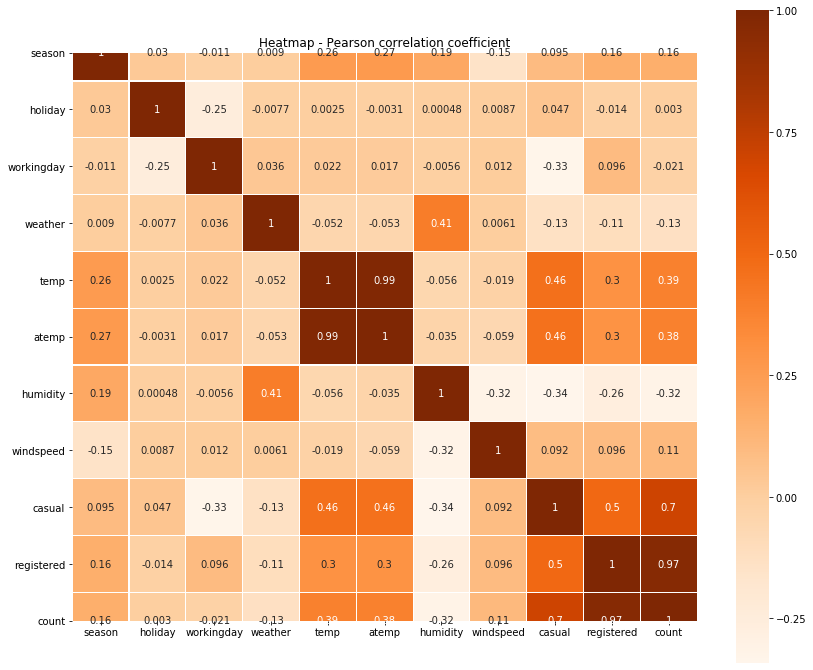

In [11]:
plt.subplots(figsize=(14,12))
sns.heatmap(df_train.corr(), linewidths = 0.1, square = True, annot = True, cmap = 'Oranges')
plt.title("Heatmap - Pearson correlation coefficient")
plt.show()

Time series: Check if there is autocorrelation on 'count'

In [12]:
print(df_train.shape)
print(df_test.shape)

(10739, 12)
(6493, 9)


In [13]:
df = df_concat(df_train, df_test)
print(df.shape)

(17232, 12)


In [14]:
# TBD remove unused y_casual and y_register
y_casual = df['casual']
y_register = df['registered']

y = df_train['count']
df_train.drop(['count'], axis =1, inplace = True)

In [15]:
df['year'] = pd.DatetimeIndex(df['datetime']).year
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['day'] = pd.DatetimeIndex(df['datetime']).date
df['weekday'] = pd.DatetimeIndex(df['datetime']).weekday
df['hour'] = df['datetime'].apply(lambda x: x.split()[1].split(':')[0])
df['hour'] = df['hour'].astype(int)
print(df.head())

         datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011/1/1 00:00       1        0           0        1  9.84  14.395   
1  2011/1/1 01:00       1        0           0        1  9.02  13.635   
2  2011/1/1 02:00       1        0           0        1  9.02  13.635   
3  2011/1/1 03:00       1        0           0        1  9.84  14.395   
4  2011/1/1 04:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month         day  \
0        81        0.0     3.0        13.0   16.0  2011      1  2011-01-01   
1        80        0.0     8.0        32.0   40.0  2011      1  2011-01-01   
2        80        0.0     5.0        27.0   32.0  2011      1  2011-01-01   
3        75        0.0     3.0        10.0   13.0  2011      1  2011-01-01   
4        75        0.0     0.0         1.0    1.0  2011      1  2011-01-01   

   weekday  hour  
0        5     0  
1        5     1  
2        5     2  
3        5     3

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17232 entries, 0 to 17231
Data columns (total 17 columns):
datetime      17232 non-null object
season        17232 non-null int64
holiday       17232 non-null int64
workingday    17232 non-null int64
weather       17232 non-null int64
temp          17232 non-null float64
atemp         17232 non-null float64
humidity      17232 non-null int64
windspeed     17232 non-null float64
casual        10739 non-null float64
registered    10739 non-null float64
count         10739 non-null float64
year          17232 non-null int64
month         17232 non-null int64
day           17232 non-null object
weekday       17232 non-null int64
hour          17232 non-null int32
dtypes: float64(6), int32(1), int64(8), object(2)
memory usage: 2.2+ MB


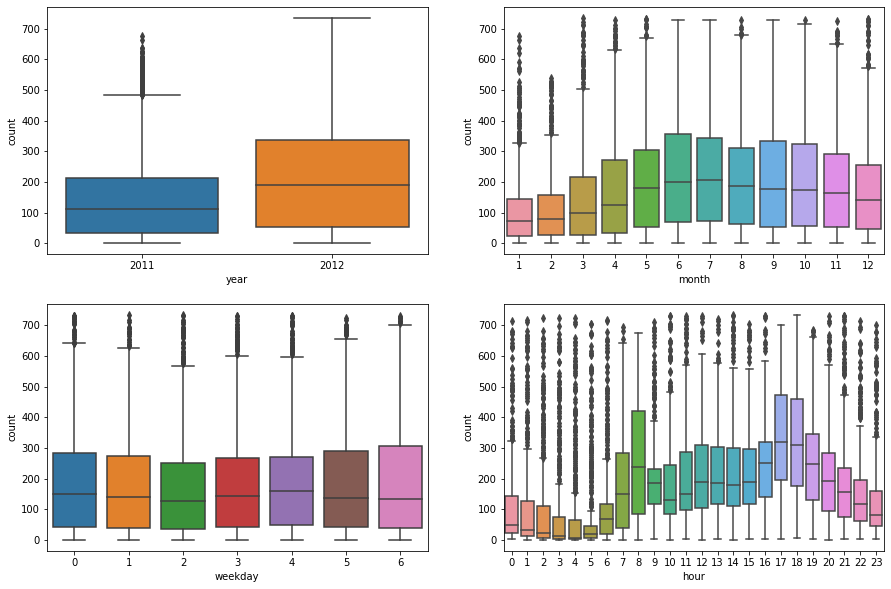

In [17]:
f, axes = plt.subplots(2,2, figsize = (15,10))
sns.boxplot(df['year'], y, ax = axes[0,0])
sns.boxplot(df['month'], y, ax = axes[0,1])
sns.boxplot(df['weekday'], y, ax = axes[1,0])
sns.boxplot(df['hour'], y, ax = axes[1,1])

TBD
1. Remove 'atemp' due to high correation with 'temp' (keep this feature).
2. Remove 'season' as 'month' can cover its effect.

Currently Saturday and Sunday are not regarded as holiday. Consider both as holiday (i.e. value = 1 for feature 'holiday')

In [18]:
df.loc[df['weekday'] > 4, 'holiday'] = 1 

In [19]:
col = ['datetime', 'day', 'season', 'workingday']
df.drop(col, axis = 1, inplace = True)

In [20]:
print(df.head(15))

    holiday  weather   temp   atemp  humidity  windspeed  casual  registered  \
0         1        1   9.84  14.395        81     0.0000     3.0        13.0   
1         1        1   9.02  13.635        80     0.0000     8.0        32.0   
2         1        1   9.02  13.635        80     0.0000     5.0        27.0   
3         1        1   9.84  14.395        75     0.0000     3.0        10.0   
4         1        1   9.84  14.395        75     0.0000     0.0         1.0   
5         1        2   9.84  12.880        75     6.0032     0.0         1.0   
6         1        1   9.02  13.635        80     0.0000     2.0         0.0   
7         1        1   8.20  12.880        86     0.0000     1.0         2.0   
8         1        1   9.84  14.395        75     0.0000     1.0         7.0   
9         1        1  13.12  17.425        76     0.0000     8.0         6.0   
10        1        1  15.58  19.695        76    16.9979    12.0        24.0   
11        1        1  14.76  16.665     

In [21]:
print(df.head(15))

    holiday  weather   temp   atemp  humidity  windspeed  casual  registered  \
0         1        1   9.84  14.395        81     0.0000     3.0        13.0   
1         1        1   9.02  13.635        80     0.0000     8.0        32.0   
2         1        1   9.02  13.635        80     0.0000     5.0        27.0   
3         1        1   9.84  14.395        75     0.0000     3.0        10.0   
4         1        1   9.84  14.395        75     0.0000     0.0         1.0   
5         1        2   9.84  12.880        75     6.0032     0.0         1.0   
6         1        1   9.02  13.635        80     0.0000     2.0         0.0   
7         1        1   8.20  12.880        86     0.0000     1.0         2.0   
8         1        1   9.84  14.395        75     0.0000     1.0         7.0   
9         1        1  13.12  17.425        76     0.0000     8.0         6.0   
10        1        1  15.58  19.695        76    16.9979    12.0        24.0   
11        1        1  14.76  16.665     

In [22]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17232 entries, 0 to 17231
Data columns (total 13 columns):
holiday       17232 non-null int64
weather       17232 non-null int64
temp          17232 non-null float64
atemp         17232 non-null float64
humidity      17232 non-null int64
windspeed     17232 non-null float64
casual        10739 non-null float64
registered    10739 non-null float64
count         10739 non-null float64
year          17232 non-null int64
month         17232 non-null int64
weekday       17232 non-null int64
hour          17232 non-null int32
dtypes: float64(6), int32(1), int64(6)
memory usage: 1.6 MB
None


None of the features below are skewed as all of them are below 0.75.

In [23]:
col = ['temp', 'atemp', 'humidity', 'windspeed']
skewness = df[col].skew().sort_values(ascending = False)
print(skewness)

windspeed    0.576959
temp         0.003095
atemp       -0.081208
humidity    -0.117105
dtype: float64


knewness of y is:  1.0283436063589986


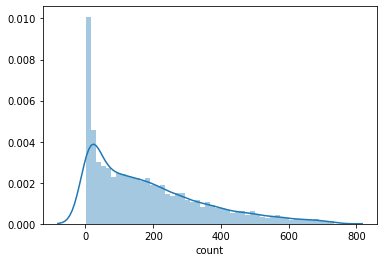

In [24]:
sns.distplot(y, bins = 50)
skewness = y.skew()
print('knewness of y is: ', skewness)
ylog = np.log1p(y)

knewness of ylog is:  -0.8705697882234272


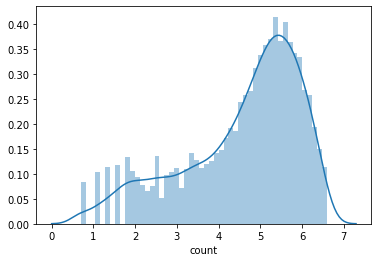

In [25]:
skewness = ylog.skew()
print('knewness of ylog is: ', skewness)
sns.distplot(ylog, bins = 50)

In [26]:
print(df_train.head())

         datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011/1/1 00:00       1        0           0        1  9.84  14.395   
1  2011/1/1 01:00       1        0           0        1  9.02  13.635   
2  2011/1/1 02:00       1        0           0        1  9.02  13.635   
3  2011/1/1 03:00       1        0           0        1  9.84  14.395   
4  2011/1/1 04:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  
0        81        0.0       3          13  
1        80        0.0       8          32  
2        80        0.0       5          27  
3        75        0.0       3          10  
4        75        0.0       0           1  


knewness of casual is:  2.5524151667964428
skewness of casuallog is:  -0.2085557941493935


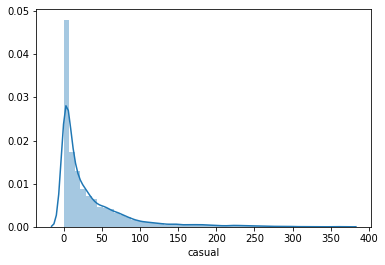

In [27]:
sns.distplot(df_train['casual'], bins = 50)
skewness = df_train['casual'].skew()
print('knewness of casual is: ', skewness)
casuallog = np.log1p(df_train['casual'])
print('skewness of casuallog is: ', casuallog.skew())

knewness of registered is:  1.2471730997982546
skewness of casuallog is:  -0.8834749658898585


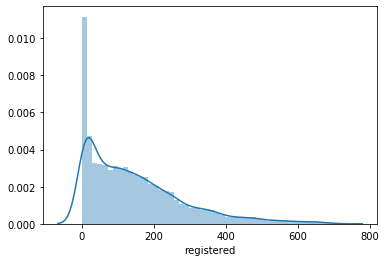

In [28]:
sns.distplot(df_train['registered'], bins = 50)
skewness = df_train['registered'].skew()
print('knewness of registered is: ', skewness)
registeredlog = np.log1p(df_train['registered'])
print('skewness of casuallog is: ', registeredlog.skew())

In [29]:
print(df.shape)
print(train_m)

(17232, 13)
10739


d_train: training dataset after feature engineering
d_test: test dataset after featur engineering

In [30]:
# Feature scaling
scaler = StandardScaler()
df_normal = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
print(df_normal.head())

    holiday   weather      temp     atemp  humidity  windspeed    casual  \
0  1.458368 -0.666755 -1.327967 -1.086319  0.942040  -1.552125 -0.650324   
1  1.458368 -0.666755 -1.431920 -1.174821  0.890189  -1.552125 -0.549405   
2  1.458368 -0.666755 -1.431920 -1.174821  0.890189  -1.552125 -0.609957   
3  1.458368 -0.666755 -1.327967 -1.086319  0.630936  -1.552125 -0.650324   
4  1.458368 -0.666755 -1.327967 -1.086319  0.630936  -1.552125 -0.710876   

   registered     count     year     month   weekday      hour  
0   -0.988410 -1.001981 -0.99664 -1.604019  0.987928 -1.662024  
1   -0.849077 -0.857987 -0.99664 -1.604019  0.987928 -1.517600  
2   -0.885744 -0.905985 -0.99664 -1.604019  0.987928 -1.373176  
3   -1.010410 -1.019980 -0.99664 -1.604019  0.987928 -1.228752  
4   -1.076410 -1.091977 -0.99664 -1.604019  0.987928 -1.084328  


In [31]:
d_train, d_test = df_split(df, train_m)
print(d_train.shape)
print(y.shape)
print(d_test.shape)
#print(d_test.head())

(10739, 13)
(10739,)
(6493, 13)


Split training dataset as two dataset: training set (for modeling) and dev set (for modeling tuning)

In [32]:
print(casuallog.shape)
print(type(casuallog))
print(registeredlog.shape)

(10739,)
<class 'pandas.core.series.Series'>
(10739,)


In [33]:
y = pd.concat([casuallog, registeredlog, y], axis = 1)
print(y.shape)
print(y.head())

(10739, 3)
     casual  registered  count
0  1.386294    2.639057     16
1  2.197225    3.496508     40
2  1.791759    3.332205     32
3  1.386294    2.397895     13
4  0.000000    0.693147      1


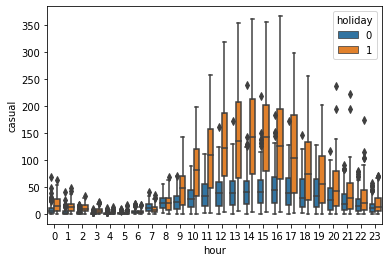

In [34]:
# TBD select the correct position. 'hour' should be incl. in df_train
#f, axes = plt.subplots(2,1, figsize = (15,10))
#sns.boxplot(x = 'hour', y = 'casual', hue = 'holiday', data = d_train, ax = axes[0,0])

sns.boxplot(x = 'hour', y = 'casual', hue = 'holiday', data = d_train)
#sns.boxplot(x = 'hour', y = 'registered', hue = 'holiday', data = d_train)

In [35]:
col = ['casual', 'registered', 'count']
d_train.drop(col, axis = 1, inplace = True)
d_test.drop(col, axis = 1, inplace = True)
n_feature = d_train.shape[1]
print(n_feature)

10


In [36]:
# Note that y_train and y_test include 3 labels: 'casual' (log1p), 'registered' (log1p), and 'count'.
X_train, X_test, y_train, y_test = train_test_split(d_train, y, test_size = 0.25, shuffle = True, random_state = 42)

In [37]:
print(X_train.head())
print(X_train.shape)
print(y_train.shape)
print(y_train.head())
print(X_test.shape)
print(y_test.shape)

      holiday  weather   temp   atemp  humidity  windspeed  year  month  \
5007        0        1  17.22  21.210        38     0.0000  2011     12   
6384        1        2  14.76  18.180        93     6.0032  2012      3   
1127        0        2  13.94  15.910        53    16.9979  2011      3   
3997        1        2  21.32  25.000        72    12.9980  2011      9   
8538        0        1  34.44  39.395        49    19.0012  2012      7   

      weekday  hour  
5007        4    17  
6384        5     6  
1127        4    15  
3997        5    14  
8538        3    12  
(8054, 10)
(8054, 3)
        casual  registered  count
5007  3.044522    5.971262    411
6384  0.693147    1.945910      7
1127  3.091042    4.174387     85
3997  4.820282    5.164786    297
8595  4.094345    5.375278    274
(2685, 10)
(2685, 3)


Use knn as the quick baseline model to observe the performance. The initial result is not bad so we can continue to apply other algorithms.

In [38]:
y_test_np = np.array(y_test['count'].to_numpy())
print(y_test_np)
print(type(y_test_np))
print(y_test_np.shape)

[ 88  54 299 ... 284 136 154]
<class 'numpy.ndarray'>
(2685,)


In [39]:
model = KNeighborsRegressor(n_neighbors = 8)
# Train model when label is 'casual'
knn = model.fit(X_train, y_train['casual'])
# Predict casual 
pred_casual = np.expm1(np.array(knn.predict(X_test)))

print(pred_casual)
print(type(pred_casual))

# Train model when label is 'casual'
knn = model.fit(X_train, y_train['registered'])
# Predict casual 
pred_registered = np.expm1(np.array(knn.predict(X_test)))
print(pred_casual)
print(type(pred_casual))

pred = pred_casual + pred_registered
rmsle = rmsle_score(y_test_np, pred, convertExp = False)
print(rmsle)

[ 8.14453183  6.24246702 42.68188091 ... 69.35209966 11.732434
 39.600291  ]
<class 'numpy.ndarray'>
[ 8.14453183  6.24246702 42.68188091 ... 69.35209966 11.732434
 39.600291  ]
<class 'numpy.ndarray'>
0.7520733794722191


In [40]:
print(X_train.shape)
print(X_train.head())
print(y_train.shape)
print(y_train.head())

(8054, 10)
      holiday  weather   temp   atemp  humidity  windspeed  year  month  \
5007        0        1  17.22  21.210        38     0.0000  2011     12   
6384        1        2  14.76  18.180        93     6.0032  2012      3   
1127        0        2  13.94  15.910        53    16.9979  2011      3   
3997        1        2  21.32  25.000        72    12.9980  2011      9   
8538        0        1  34.44  39.395        49    19.0012  2012      7   

      weekday  hour  
5007        4    17  
6384        5     6  
1127        4    15  
3997        5    14  
8538        3    12  
(8054, 3)
        casual  registered  count
5007  3.044522    5.971262    411
6384  0.693147    1.945910      7
1127  3.091042    4.174387     85
3997  4.820282    5.164786    297
8595  4.094345    5.375278    274


In [41]:
for n in [3, 6, n_feature]:
    model = KNeighborsRegressor(n_neighbors = n)
    knn = model.fit(X_train, y_train['casual'])
    score = knn.score(X_train, y_train['casual'])
    print('Training set score (predict casual): ', score)
    score = knn.score(X_test, y_test['casual'])
    print('Dev set score (predict casual): ', score)
    
    # Predict casual 
    pred_casual = np.expm1(np.array(knn.predict(X_test)))
    
    knn = model.fit(X_train, y_train['registered'])
    score = knn.score(X_train, y_train['registered'])
    print('Training set score (predict registered): ', score)
    score = knn.score(X_test, y_test['registered'])
    print('Dev set score (predict registered): ', score)
    
    # Predict registered
    pred_registered = np.expm1(np.array(knn.predict(X_test)))
       
    pred = pred_casual + pred_registered
    score = rmsle_score(y_test_np, pred, convertExp = False)    
    print('rmsle for knn: ', score)

Training set score (predict casual):  0.8752866304659656
Dev set score (predict casual):  0.7540821773938092
Training set score (predict registered):  0.842686546912752
Dev set score (predict registered):  0.6979816157083112
rmsle for knn:  0.7373842231880166
Training set score (predict casual):  0.8289223913859551
Dev set score (predict casual):  0.7599478355293459
Training set score (predict registered):  0.7746045255144259
Dev set score (predict registered):  0.7004664281524522
rmsle for knn:  0.735375528645699
Training set score (predict casual):  0.7998995871924113
Dev set score (predict casual):  0.7498744171910278
Training set score (predict registered):  0.7245201203376643
Dev set score (predict registered):  0.6788046485149075
rmsle for knn:  0.7619044747961728


In [42]:
for n_f in [5, 8, n_feature]:
    for n_d in [3, 7, n_feature]:
        model = RandomForestRegressor(n_estimators = 800,
                              max_features = n_f,
                              max_depth = n_d,
                              oob_score = True,
                              random_state = 0)
        rf = model.fit(X_train, y_train['casual'])
        score = rf.score(X_train, y_train['casual'])
        print('Train set score (predicct casual):', score)
        score = rf.score(X_test, y_test['casual'])
        print('Dev set score (predicct casual): ', score)
        
        # Predict casual
        pred_casual = np.expm1(np.array(rf.predict(X_test)))
        
        rf = model.fit(X_train, y_train['registered'])
        score = rf.score(X_train, y_train['registered'])
        print('Training set score (predict registered): ', score)
        score = rf.score(X_test, y_test['registered'])
        print('Dev set score (predict registered): ', score)
        
        # Predict registered
        pred_registered = np.expm1(np.array(rf.predict(X_test)))        
        
        pred = pred_casual + pred_registered
        score = rmsle_score(y_test_np, pred, convertExp = False)
        print('Random Forest rmsle for max_feature=', n_f, 'and max_depth=', n_d, ' is: ', score)

Train set score (predicct casual): 0.717762812446352
Dev set score (predicct casual):  0.706194218844014
Training set score (predict registered):  0.716314478416133
Dev set score (predict registered):  0.7175623206987405
Random Forest rmsle for max_feature= 5 and max_depth= 3  is:  0.7218712689448262
Train set score (predicct casual): 0.8739462138261681
Dev set score (predicct casual):  0.8476237209996192
Training set score (predict registered):  0.8929263791785294
Dev set score (predict registered):  0.8893645859297375
Random Forest rmsle for max_feature= 5 and max_depth= 7  is:  0.4444037889355795
Train set score (predicct casual): 0.932091965693838
Dev set score (predicct casual):  0.8796552661497938
Training set score (predict registered):  0.954422340719244
Dev set score (predict registered):  0.9340976859890261
Random Forest rmsle for max_feature= 5 and max_depth= 10  is:  0.3449006586550244
Train set score (predicct casual): 0.7077058396443117
Dev set score (predicct casual):  0

In [43]:
for trees in [500, 700, 1000]:
    for lr in [0.05, 0.1, 0.5]:
        for m_d in [3, 4, 5, 6]: 
            model = GradientBoostingRegressor(n_estimators = trees, learning_rate = lr, max_depth = m_d)
            print('n_estimators=', trees, ', learning_rate=', lr, 'max_depth=', m_d)
            gb = model.fit(X_train, y_train['casual']) 
            score = gb.score(X_train, y_train['casual'])
            #print('Training set score (predicct casual): ', score)
            score = gb.score(X_test, y_test['casual'])
            #print('Dev set score (predicct casual): ', score)
            
            # Predict casual
            pred_casual = np.expm1(np.array(gb.predict(X_test)))
            
            gb = model.fit(X_train, y_train['registered'])
            score = gb.score(X_train, y_train['registered'])
            #print('Training set score (predict registered): ', score)
            score = gb.score(X_test, y_test['registered'])
            #print('Dev set score (predict registered): ', score)
        
            # Predict registered
            pred_registered = np.expm1(np.array(gb.predict(X_test)))            
            
            pred = pred_casual + pred_registered
            score = rmsle_score(y_test_np, pred, convertExp = False)
            print('Gradient boost rmsle is: ', score)

n_estimators= 500 , learning_rate= 0.05 max_depth= 3
Gradient boost rmsle is:  0.29490949477360356
n_estimators= 500 , learning_rate= 0.05 max_depth= 4
Gradient boost rmsle is:  0.27759496363999486
n_estimators= 500 , learning_rate= 0.05 max_depth= 5
Gradient boost rmsle is:  0.27427678164679165
n_estimators= 500 , learning_rate= 0.05 max_depth= 6
Gradient boost rmsle is:  0.274144093741698
n_estimators= 500 , learning_rate= 0.1 max_depth= 3
Gradient boost rmsle is:  0.2871954887904892
n_estimators= 500 , learning_rate= 0.1 max_depth= 4
Gradient boost rmsle is:  0.2770002362454162
n_estimators= 500 , learning_rate= 0.1 max_depth= 5
Gradient boost rmsle is:  0.2780549069913097
n_estimators= 500 , learning_rate= 0.1 max_depth= 6
Gradient boost rmsle is:  0.2794797885081508
n_estimators= 500 , learning_rate= 0.5 max_depth= 3
Gradient boost rmsle is:  0.2933112466388514
n_estimators= 500 , learning_rate= 0.5 max_depth= 4
Gradient boost rmsle is:  0.305519351401619
n_estimators= 500 , learn

In [45]:
# n_estimators= 500 , learning_rate= 0.05 max_depth= 6
model = GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.05, max_depth = 6)

gb1 = model.fit(X_train, y_train['casual']) 
score = gb1.score(X_train, y_train['casual'])
print('Training set score (predicct casual): ', score)
score = gb1.score(X_test, y_test['casual'])
print('Dev set score (predicct casual): ', score)
            
# Predict casual
pred_casual = np.expm1(np.array(gb1.predict(X_test)))
            
gb2 = model.fit(X_train, y_train['registered'])
score = gb2.score(X_train, y_train['registered'])
print('Training set score (predict registered): ', score)
score = gb2.score(X_test, y_test['registered'])
print('Dev set score (predict registered): ', score)
        
# Predict registered
pred_registered = np.expm1(np.array(gb2.predict(X_test)))            
            
pred = pred_casual + pred_registered
print(pred)
score = rmsle_score(y_test_np, pred, convertExp = False)
print('Gradient boost rmsle is: ', score)

Training set score (predicct casual):  0.9589938587620025
Dev set score (predicct casual):  0.8938512026292051
Training set score (predict registered):  0.9855432671202694
Dev set score (predict registered):  0.9606546933905261
[ 91.22212144  30.91497719 260.27433441 ... 289.6413245  136.16565676
 145.37423809]
Gradient boost rmsle is:  0.2736685436103018


In [46]:
print(d_test.columns)

Index(['holiday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year',
       'month', 'weekday', 'hour'],
      dtype='object')


In [47]:
# Predict casual and registered seperately
pred_casual_t = gb1.predict(d_test)
pred_casual_t[pred_casual_t < 0 ] = 0
pred_casual_t = np.expm1(np.array(pred_casual_t))
pred_register_t = gb2.predict(d_test)
pred_register_t[pred_register_t < 0] = 0
pred_register_t = np.expm1(np.array(pred_register_t))
pred = pred_casual_t + pred_register_t
#pred = pred.astype(int)
np.savetxt('pred.csv', pred, delimiter = ',')